
# Optimization of Pricing and Customer Segmentation using Genetic Algorithm


In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

In [26]:
class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, crossover_rate, data):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.data = data
        self.population = self.initialize_population()

    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            chromosome = {
                'discount': random.uniform(0, 0.8),
                'sales_multiplier': random.uniform(0.5, 1.5)
            }
            population.append(chromosome)
        return population

    def fitness(self, chromosome):
        total_profit = 0
        for index, row in self.data.iterrows():
            discount = chromosome['discount']
            sales_multiplier = chromosome['sales_multiplier']
            profit_row = row['Profit'] * sales_multiplier * (1 - discount)
            total_profit += profit_row
        return total_profit

    def selection(self):
        fitness_values = [self.fitness(chromosome) for chromosome in self.population]
        pairs = []
        for _ in range(self.population_size // 2):
            parent1_index = self.roulette_wheel_selection(fitness_values)
            parent2_index = self.roulette_wheel_selection(fitness_values)
            pairs.append((self.population[parent1_index], self.population[parent2_index]))
        return pairs

    def roulette_wheel_selection(self, fitness_values):
        total_fitness = sum(fitness_values)
        probabilities = [f / total_fitness for f in fitness_values]
        r = random.random()
        cumulative_probability = 0
        for i, probability in enumerate(probabilities):
            cumulative_probability += probability
            if r <= cumulative_probability:
                return i
        return len(fitness_values) - 1

    def crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            child = {
                'discount': parent1['discount'] if random.random() < 0.5 else parent2['discount'],
                'sales_multiplier': parent1['sales_multiplier'] if random.random() < 0.5 else parent2['sales_multiplier']
            }
            return child
        else:
            return parent1

    def mutate(self, chromosome):
        mutated_chromosome = chromosome.copy()
        if random.random() < self.mutation_rate:
            mutated_chromosome['discount'] = random.uniform(0, 0.8)
        if random.random() < self.mutation_rate:
            mutated_chromosome['sales_multiplier'] = random.uniform(0.5, 1.5)
        return mutated_chromosome

    def evolve(self, generations):
        best_fitness_history = []
        for generation in range(generations):
            pairs = self.selection()
            new_population = []
            for parent1, parent2 in pairs:
                child1 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                new_population.append(child1)
            self.population = new_population

            best_chromosome = max(self.population, key=self.fitness)
            best_fitness = self.fitness(best_chromosome)
            best_fitness_history.append(best_fitness)
            print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")
        return best_fitness_history

    def get_results(self):
         best_chromosome = max(self.population, key=self.fitness)
         total_profit = self.fitness(best_chromosome)
         results_df = pd.DataFrame({
            'Total Profit': [total_profit],
            'Discount': [best_chromosome['discount']],
            'Sales Multiplier': [best_chromosome['sales_multiplier']]
        })
         return results_df



In [27]:
def preprocess_data(df):
    df = df.copy()
    for col in df.columns:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].mean())
    categorical_cols = ['Category', 'Sub-Category', 'Segment']
    for col in categorical_cols:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_features = encoder.fit_transform(df[[col]])
        encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out([col]))
        df = pd.concat([df, encoded_df], axis=1)
        df.drop(col, axis=1, inplace=True)
    return df


In [28]:
def cluster_customers(df, n_clusters=3):
    df_clustering = df.copy()
    features_for_clustering = ['Sales', 'Quantity', 'Discount', 'Profit']
    df_clustering = df_clustering[features_for_clustering]

    # Scaling the features
    scaler = StandardScaler()
    df_clustering_scaled = scaler.fit_transform(df_clustering)

    # Perform KMeans clustering on the scaled data without PCA
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_clustering['Cluster'] = kmeans.fit_predict(df_clustering_scaled)

    return df_clustering


In [29]:
def plot_clustering(df):
    plt.figure(figsize=(10, 6))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta']
    for cluster in df['Cluster'].unique():
        cluster_data = df[df['Cluster'] == cluster]
        plt.scatter(cluster_data['Sales'], cluster_data['Profit'], label=f'Cluster {cluster}', alpha=0.6)
    plt.title('Customer Clusters')
    plt.xlabel('Sales')
    plt.ylabel('Profit')
    plt.legend()
    plt.show()

def plot_genetic_algorithm_progress(best_fitness_history):
    generations = range(1, len(best_fitness_history) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(generations, best_fitness_history)
    plt.title('Best Fitness Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness (Total Profit)')
    plt.show()

def predict_sales(df):
    df_prediction = df.copy()
    features = ['Sales', 'Quantity', 'Discount', 'Profit']
    train_data, test_data = train_test_split(df_prediction, test_size=0.2, random_state=42)

    X_train = train_data[features]
    y_train = train_data['Sales']
    X_test = test_data[features]
    y_test = test_data['Sales']

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    return y_pred, model, X_test, y_test

def plot_sales_predictions(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Sales")
    plt.ylabel("Predicted Sales")
    plt.title("Actual vs Predicted Sales")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.show()


Generation 1: Best Fitness = 426578.0463438655
Generation 2: Best Fitness = 417811.80850803293
Generation 3: Best Fitness = 417811.80850803293
Generation 4: Best Fitness = 350166.11271243275
Generation 5: Best Fitness = 359444.97038513556
Generation 6: Best Fitness = 354425.0081215428
Generation 7: Best Fitness = 346915.74518209446
Generation 8: Best Fitness = 319793.42039524025
Generation 9: Best Fitness = 346508.12006557256
Generation 10: Best Fitness = 398107.40961825347
Generation 11: Best Fitness = 398107.40961825347
Generation 12: Best Fitness = 398107.40961825347
Generation 13: Best Fitness = 398107.40961825347
Generation 14: Best Fitness = 398107.40961825347
Generation 15: Best Fitness = 398107.40961825347
Generation 16: Best Fitness = 398107.40961825347
Generation 17: Best Fitness = 370457.3721450963
Generation 18: Best Fitness = 387830.50412048516
Generation 19: Best Fitness = 387830.50412048516
Generation 20: Best Fitness = 370457.3721450963
Generation 21: Best Fitness = 370

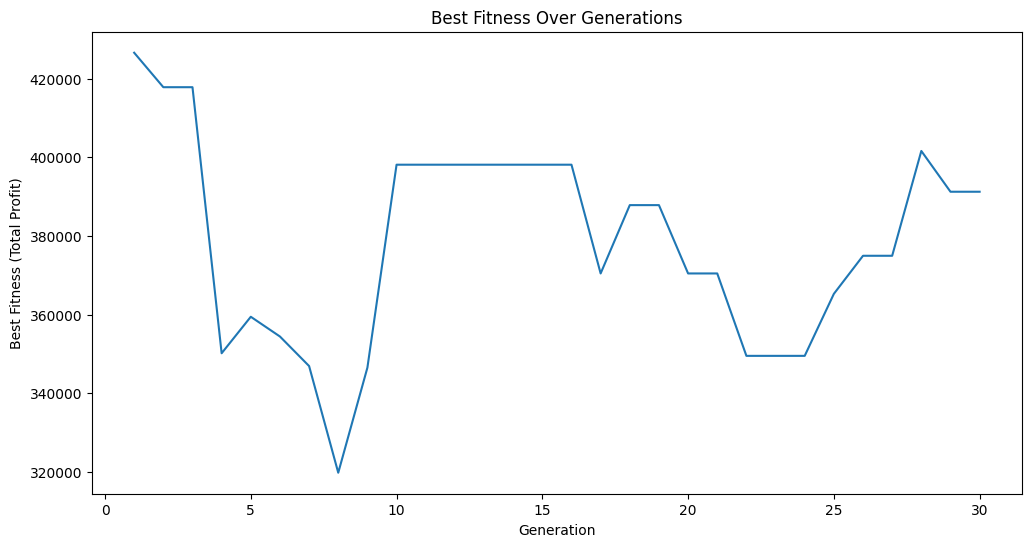

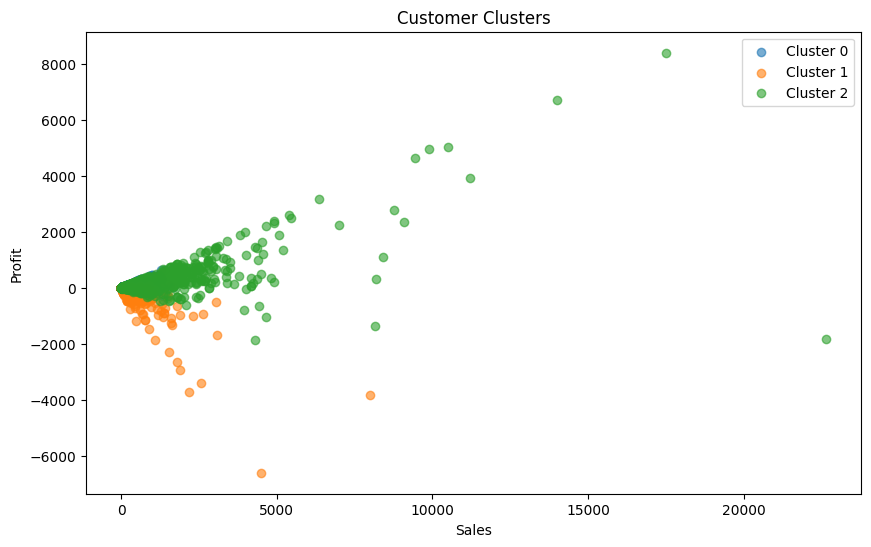

Mean Squared Error: 2.5814963640412892e-26
Sales Predictions:
[563.808  36.672  37.3   ...  16.68  479.988 352.45 ]


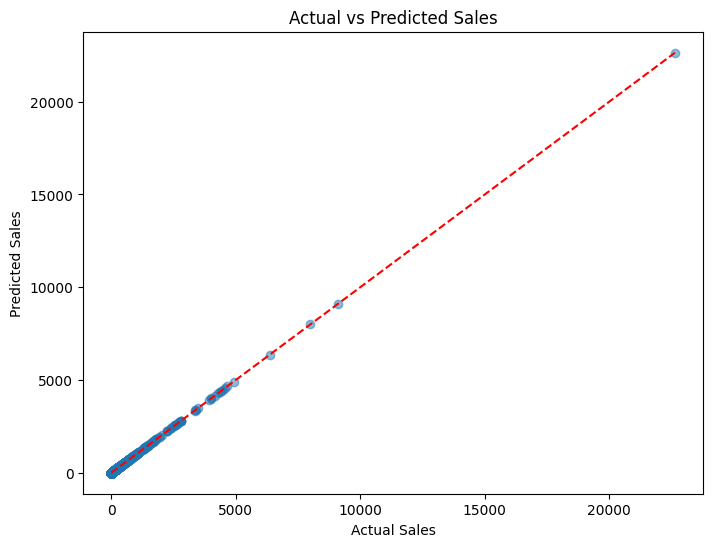

In [30]:
# Load the data
df1 = pd.read_excel('Superstore.xlsx')

# Preprocess the data
df_preprocessed = preprocess_data(df1)

# Initialize and run the genetic algorithm
ga = GeneticAlgorithm(population_size=50, mutation_rate=0.1, crossover_rate=0.8, data=df_preprocessed)
best_fitness_history = ga.evolve(generations=30)

# Get and display the results of the genetic algorithm
results_df = ga.get_results()
print("\nGenetic Algorithm Results:")
print(results_df)

# Print the best chromosome
best_chromosome = results_df.loc[0]
print("\nBest Chromosome:")
print(f"Discount: {best_chromosome['Discount']}, Sales Multiplier: {best_chromosome['Sales Multiplier']}, Total Profit: {best_chromosome['Total Profit']}")

# Plot genetic algorithm progress
plot_genetic_algorithm_progress(best_fitness_history)

# Perform customer clustering
df_clustered = cluster_customers(df_preprocessed)

# Plot customer clusters
plot_clustering(df_clustered)

# Predict Sales
y_pred, model, X_test, y_test = predict_sales(df_preprocessed)
print("Sales Predictions:")
print(y_pred)

# Plot Sales Predictions
plot_sales_predictions(y_test, y_pred)

# clustring with K-Means


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random

In [23]:
class GeneticClustering:
    def __init__(self, data, n_clusters, population_size, mutation_rate, crossover_rate):
        self.data = data
        self.n_clusters = n_clusters
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.population = self.initialize_population()

    def initialize_population(self):
        # Initialize population with random cluster assignments
        return [self.random_chromosome() for _ in range(self.population_size)]

    def random_chromosome(self):
        return np.random.randint(0, self.n_clusters, size=len(self.data))

    def fitness(self, cluster_assignments):
        # Calculate the Mean Squared Error
        mse = mean_squared_error(self.data, self.data[cluster_assignments])
        return -mse  # Minimize MSE, but make it positive for maximization

    def selection(self):
        # Select the best chromosomes based on fitness (MSE)
        fitness_scores = [self.fitness(chromosome) for chromosome in self.population]
        return [self.population[i] for i in np.argsort(fitness_scores)[-2:]]  # Select top 2 chromosomes

    def crossover(self, parent1, parent2):
        # Perform crossover to create a child chromosome
        child = parent1.copy()
        for i in range(len(child)):
            if random.random() < self.crossover_rate:
                child[i] = parent2[i]
        return child

    def mutate(self, chromosome):
        # Perform mutation on a chromosome
        for i in range(len(chromosome)):
            if random.random() < self.mutation_rate:
                chromosome[i] = random.randint(0, self.n_clusters - 1)
        return chromosome

    def evolve(self, generations):
        for _ in range(generations):
            new_population = []
            selected_parents = self.selection()
            for _ in range(self.population_size):
                parent1, parent2 = selected_parents
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                new_population.append(child)
            self.population = new_population

        # Return the best chromosome after evolution
        best_chromosome = max(self.population, key=self.fitness)
        return best_chromosome


Mean Squared Error: 1.3526617538761048
              Sales  Quantity     Profit  Discount
Cluster                                           
0        203.429829  3.736231  20.111039  0.159440
1        285.915589  3.893598  47.116409  0.150070
2        201.513244  3.741282  19.166087  0.158957


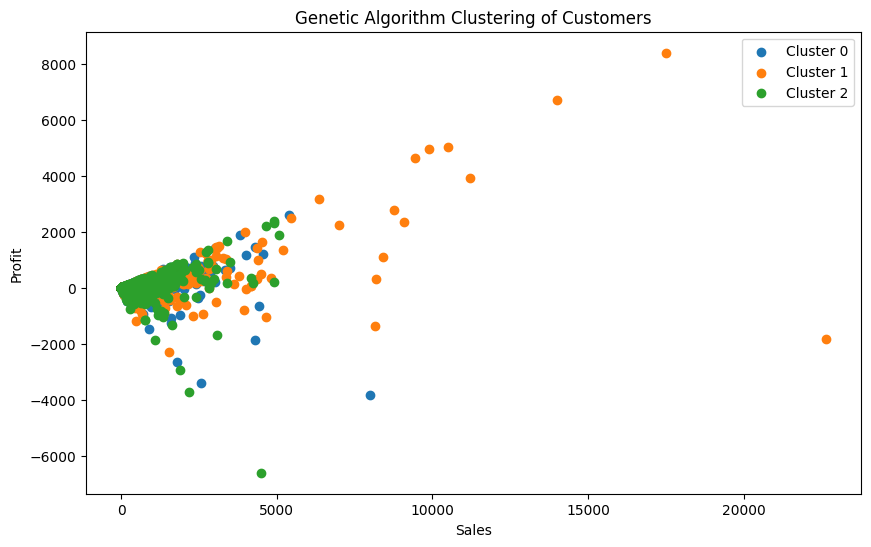

In [24]:
# Load the data and preprocess
df = pd.read_excel('Superstore.xlsx')

# Select features for clustering
features = ['Sales', 'Quantity', 'Profit', 'Discount']  # Features to cluster
data = df[features].dropna().values  # Remove missing values
scaler = StandardScaler()  # Initialize scaler
data_scaled = scaler.fit_transform(data)  # Scale the data

# Run the genetic clustering algorithm
n_clusters = 3  # Number of clusters
genetic_clustering = GeneticClustering(data_scaled, n_clusters=n_clusters, population_size=50, mutation_rate=0.01, crossover_rate=0.7)
best_chromosome = genetic_clustering.evolve(generations=30)  # Execute the genetic algorithm

# Add results to DataFrame
df['Cluster'] = best_chromosome  # Specify cluster in the DataFrame

# Calculate Mean Squared Error (MSE)
predicted_values = np.array([data_scaled[i] for i in best_chromosome])  # Predicted values based on clustering
mse = mean_squared_error(data_scaled, predicted_values)  # Calculate MSE
print(f"Mean Squared Error: {mse}")  # Print MSE

# Clustering results
print(df.groupby('Cluster')[features].mean())  # Print mean of features by cluster

# Plot clustering results
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_data = df[df['Cluster'] == cluster]  # Data for each cluster
    plt.scatter(cluster_data['Sales'], cluster_data['Profit'], label=f'Cluster {cluster}')  # Plot points

plt.title('Genetic Algorithm Clustering of Customers')  # Title of the plot
plt.xlabel('Sales')  # X-axis label
plt.ylabel('Profit')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot